## Try SAM on the Bees 

To create a SAM environment

conda create --name ultralytics-env python=3.8 -y

conda activate ultralytics-env

conda install -c pytorch -c nvidia -c conda-forge pytorch torchvision pytorch-cuda=11.8 ultralytics

original min max 0 255


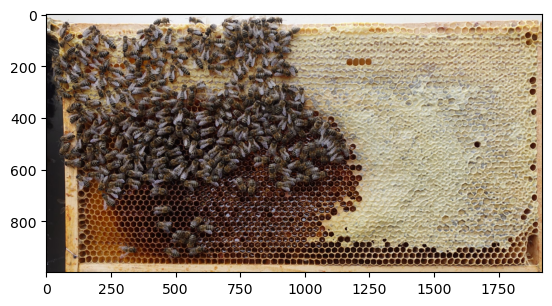

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.backends
import matplotlib.pyplot as plt
from skimage.io import imread

tnia_images_path = Path(r'D:/images')


parent_path=Path(tnia_images_path / r'tnia-python-images/imagesc/2023_12_20_segmenting_bees')
test_name='bsp1-2.jpg'

testim = imread(parent_path  / test_name) 
testim.shape
plt.imshow(testim, cmap="gray")
print('original min max', testim.min(), testim.max())

In [4]:
from ultralytics import SAM 
import logging                                                                 
logging.getLogger('ultralytics').setLevel(logging.CRITICAL) 

In [5]:
model_base = SAM("sam_b.pt") # Downloads base model - it's about 300MB.
results = model_base.predict( parent_path  / test_name) # 

100%|██████████| 358M/358M [00:11<00:00, 31.6MB/s] 


In [6]:
def make_label_image(label_image, masks):
    '''
    Creates a label image by adding one mask at a time onto an empty image, given the masks from an ultralytics prediction

    Inputs:
    - A label image of zeros, in the same size and shape of your original image.
    - A list of masks from an ultralytics segmentation
    Outputs:
    - A label-image of all masks
    '''
    for enum, mask in enumerate(masks):
        curr_label = mask.data.cpu().numpy() # Converts from tensors to a numpy compatible array on the CPU
        mnarray = curr_label.squeeze() # reduce each mask into 2D array
        label_image[mnarray] = enum + 1 # set each mask to a unique ID (enum)

    return(label_image)

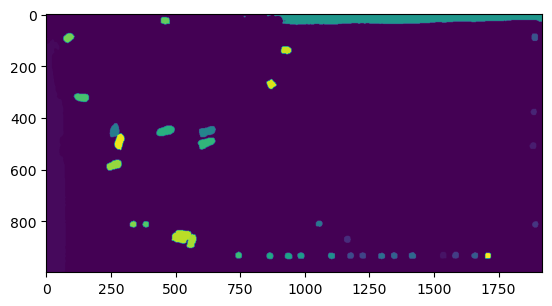

In [7]:
masks = results[0].masks # Ultralytics masks are in the results
array_shape = [masks.shape[1], masks.shape[2]] # Getting the 2D shape
label_image_zeros = np.zeros(array_shape, dtype=np.int32) # Creates a label image of zeros
label_image = make_label_image(label_image_zeros, masks)
plt.imshow(label_image)

In [9]:
import napari
viewer = napari.Viewer()
viewer.add_image(testim, name='original')
viewer.add_labels(label_image, name='SAM segmentation')

<Labels layer 'SAM segmentation' at 0x1994d844bb0>